## Using Arima Time Series Model on Carbon Dioxide Levels in Atmosphere Data
## Source: https://www.kaggle.com/datasets/ucsandiego/carbon-dioxide?resource=download
## Description: The carbon dioxide record from Mauna Loa Observatory, known as the “Keeling Curve,” is the world’s longest unbroken record of atmospheric carbon dioxide concentrations. Scientists make atmospheric measurements in remote locations to sample air that is representative of a large volume of Earth’s atmosphere and relatively free from local influences.
## Author: Stephen Situ 

### Pip Install

In [138]:
!pip install numpy pandas scikit-learn matplotlib statsmodels

### Imports

In [146]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### Read Data

In [147]:
df = pd.read_csv("archive.csv")
df

,Year,Month,Decimal Date,Carbon Dioxide (ppm),Seasonally Adjusted CO2 (ppm),Carbon Dioxide Fit (ppm),Seasonally Adjusted CO2 Fit (ppm)
0,1958,1,1958.0411,NaN,NaN,NaN,NaN
1,1958,2,1958.1260,NaN,NaN,NaN,NaN
2,1958,3,1958.2027,315.69,314.42,316.18,314.89
3,1958,4,1958.2877,317.45,315.15,317.30,314.98
4,1958,5,1958.3699,317.50,314.73,317.83,315.06
...,...,...,...,...,...,...,...
715,2017,8,2017.6219,NaN,NaN,NaN,NaN
716,2017,9,2017.7068,NaN,NaN,NaN,NaN
717,2017,10,2017.7890,NaN,NaN,NaN,NaN
718,2017,11,2017.8740,NaN,NaN,NaN,NaN


### Drop rows if they are all null

In [148]:
columns_to_check = [
    "Carbon Dioxide (ppm)",
    "Seasonally Adjusted CO2 (ppm)",
    "Carbon Dioxide Fit (ppm)",
    "Seasonally Adjusted CO2 Fit (ppm)"
]
df = df.dropna(subset=columns_to_check, how='all')
df.reset_index(drop=True)
df

,Year,Month,Decimal Date,Carbon Dioxide (ppm),Seasonally Adjusted CO2 (ppm),Carbon Dioxide Fit (ppm),Seasonally Adjusted CO2 Fit (ppm)
2,1958,3,1958.2027,315.69,314.42,316.18,314.89
3,1958,4,1958.2877,317.45,315.15,317.30,314.98
4,1958,5,1958.3699,317.50,314.73,317.83,315.06
5,1958,6,1958.4548,NaN,NaN,317.22,315.14
6,1958,7,1958.5370,315.86,315.17,315.87,315.21
...,...,...,...,...,...,...,...
705,2016,10,2016.7896,401.50,405.12,401.48,405.09
706,2016,11,2016.8743,403.64,405.92,403.08,405.34
707,2016,12,2016.9563,404.55,405.49,404.66,405.58
708,2017,1,2017.0411,406.07,406.04,405.87,405.83


### Impute using KNN Imputer

In [149]:
imputer = KNNImputer(n_neighbors=3)
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df

,Year,Month,Decimal Date,Carbon Dioxide (ppm),Seasonally Adjusted CO2 (ppm),Carbon Dioxide Fit (ppm),Seasonally Adjusted CO2 Fit (ppm)
0,1958.0,3.0,1958.2027,315.69,314.420000,316.180000,314.89
1,1958.0,4.0,1958.2877,317.45,315.150000,317.300000,314.98
2,1958.0,5.0,1958.3699,317.50,314.730000,317.830000,315.06
3,1958.0,6.0,1958.4548,317.17,315.313333,317.220000,315.14
4,1958.0,7.0,1958.5370,315.86,315.170000,315.870000,315.21
...,...,...,...,...,...,...,...
703,2016.0,10.0,2016.7896,401.50,405.120000,401.480000,405.09
704,2016.0,11.0,2016.8743,403.64,405.920000,403.080000,405.34
705,2016.0,12.0,2016.9563,404.55,405.490000,404.660000,405.58
706,2017.0,1.0,2017.0411,406.07,406.040000,405.870000,405.83


### Create Date Column

In [150]:
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))
# Identify the 'Date' column
date_col = 'Date'
# Get all other columns
other_cols = list(set(df.columns) - {date_col})
# Rearrange the columns to make 'Date' the first column
df = df[[date_col] + other_cols]
df

,Date,Carbon Dioxide (ppm),Seasonally Adjusted CO2 Fit (ppm),Month,Carbon Dioxide Fit (ppm),Decimal Date,Seasonally Adjusted CO2 (ppm),Year
0,1958-03-01,315.69,314.89,3.0,316.180000,1958.2027,314.420000,1958.0
1,1958-04-01,317.45,314.98,4.0,317.300000,1958.2877,315.150000,1958.0
2,1958-05-01,317.50,315.06,5.0,317.830000,1958.3699,314.730000,1958.0
3,1958-06-01,317.17,315.14,6.0,317.220000,1958.4548,315.313333,1958.0
4,1958-07-01,315.86,315.21,7.0,315.870000,1958.5370,315.170000,1958.0
...,...,...,...,...,...,...,...,...
703,2016-10-01,401.50,405.09,10.0,401.480000,2016.7896,405.120000,2016.0
704,2016-11-01,403.64,405.34,11.0,403.080000,2016.8743,405.920000,2016.0
705,2016-12-01,404.55,405.58,12.0,404.660000,2016.9563,405.490000,2016.0
706,2017-01-01,406.07,405.83,1.0,405.870000,2017.0411,406.040000,2017.0


### Drop other date columns

In [151]:
df = df.drop(columns=['Year', 'Month', 'Decimal Date'])
df

,Date,Carbon Dioxide (ppm),Seasonally Adjusted CO2 Fit (ppm),Carbon Dioxide Fit (ppm),Seasonally Adjusted CO2 (ppm)
0,1958-03-01,315.69,314.89,316.180000,314.420000
1,1958-04-01,317.45,314.98,317.300000,315.150000
2,1958-05-01,317.50,315.06,317.830000,314.730000
3,1958-06-01,317.17,315.14,317.220000,315.313333
4,1958-07-01,315.86,315.21,315.870000,315.170000
...,...,...,...,...,...
703,2016-10-01,401.50,405.09,401.480000,405.120000
704,2016-11-01,403.64,405.34,403.080000,405.920000
705,2016-12-01,404.55,405.58,404.660000,405.490000
706,2017-01-01,406.07,405.83,405.870000,406.040000


### Visualize Time Series

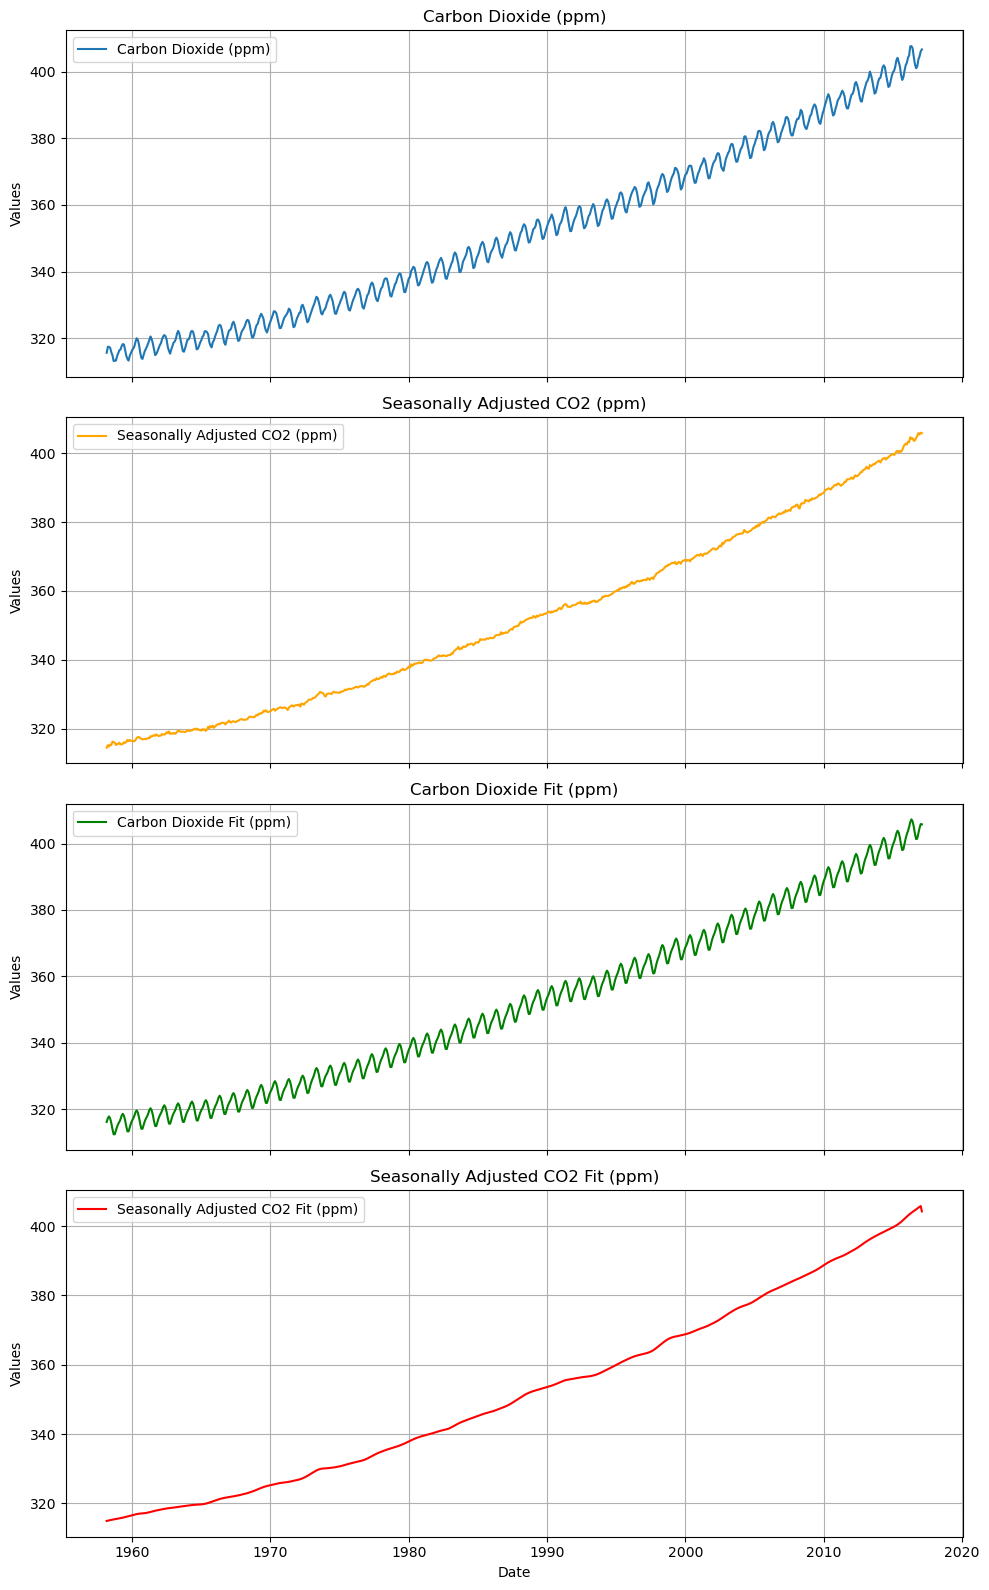

In [152]:
# Plot each series in a separate chart
fig, axs = plt.subplots(4, 1, figsize=(10, 16), sharex=True)

# Plot Carbon Dioxide (ppm)
axs[0].plot(df['Date'], df['Carbon Dioxide (ppm)'], label='Carbon Dioxide (ppm)')
axs[0].set_title('Carbon Dioxide (ppm)')
axs[0].set_ylabel('Values')
axs[0].legend()
axs[0].grid(True)

# Plot Seasonally Adjusted CO2 (ppm)
axs[1].plot(df['Date'], df['Seasonally Adjusted CO2 (ppm)'], label='Seasonally Adjusted CO2 (ppm)', color='orange')
axs[1].set_title('Seasonally Adjusted CO2 (ppm)')
axs[1].set_ylabel('Values')
axs[1].legend()
axs[1].grid(True)

# Plot Carbon Dioxide Fit (ppm)
axs[2].plot(df['Date'], df['Carbon Dioxide Fit (ppm)'], label='Carbon Dioxide Fit (ppm)', color='green')
axs[2].set_title('Carbon Dioxide Fit (ppm)')
axs[2].set_ylabel('Values')
axs[2].legend()
axs[2].grid(True)

# Plot Seasonally Adjusted CO2 Fit (ppm)
axs[3].plot(df['Date'], df['Seasonally Adjusted CO2 Fit (ppm)'], label='Seasonally Adjusted CO2 Fit (ppm)', color='red')
axs[3].set_title('Seasonally Adjusted CO2 Fit (ppm)')
axs[3].set_ylabel('Values')
axs[3].legend()
axs[3].grid(True)
axs[3].set_xlabel('Date')

plt.tight_layout()
plt.show()

### Check if data is stationary or not for ARIMA model, if it is not stationary we must difference it

In [153]:
# Check for stationarity
result = adfuller(df['Carbon Dioxide (ppm)'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: 4.8470251982655315
p-value: 1.0


ADF Statistic after differencing: -4.7536105546080805
p-value after differencing: 6.665929622431172e-05


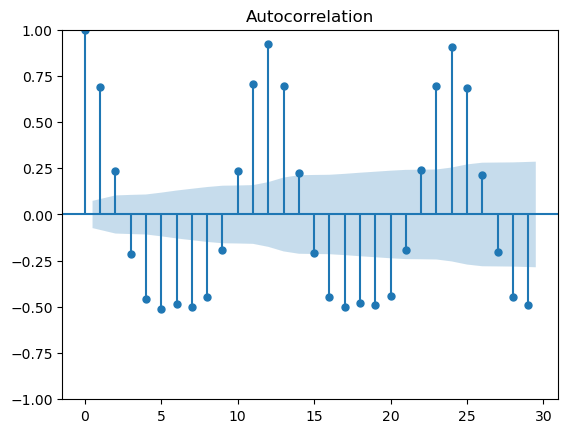

C:\Users\steph\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


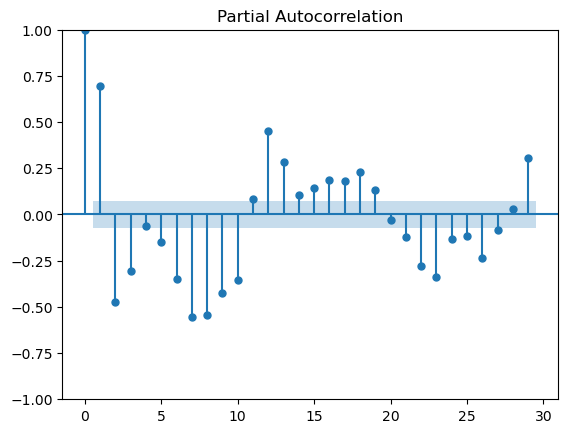

                                SARIMAX Results                                
Dep. Variable:     Carbon Dioxide Diff   No. Observations:                  708
Model:                SARIMAX(1, 0, 1)   Log Likelihood                -880.403
Date:                 Wed, 12 Jun 2024   AIC                           1766.805
Time:                         14:12:26   BIC                           1780.492
Sample:                              0   HQIC                          1772.093
                                 - 708                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5570      0.042     13.246      0.000       0.475       0.639
ma.L1          0.3559      0.048      7.403      0.000       0.262       0.450
sigma2         0.7057      0.045     15.695 

In [154]:
# Differencing if not stationary
if result[1] > 0.05:
    df['Carbon Dioxide Diff'] = df['Carbon Dioxide (ppm)'].diff().dropna()
    # Check for stationarity again after differencing
    result = adfuller(df['Carbon Dioxide Diff'].dropna())
    print('ADF Statistic after differencing:', result[0])
    print('p-value after differencing:', result[1])

    # Plot ACF and PACF for the differenced series
    plot_acf(df['Carbon Dioxide Diff'].dropna())
    plt.show()

    plot_pacf(df['Carbon Dioxide Diff'].dropna())
    plt.show()

    # Fit ARIMA model on the differenced series
    model = SARIMAX(df['Carbon Dioxide Diff'], order=(1, 0, 1))
else:
    # Fit ARIMA model on the original series
    model = SARIMAX(df['Carbon Dioxide (ppm)'], order=(1, 1, 1))

model_fit = model.fit(disp=False)
print(model_fit.summary())

### Make forecast

In [155]:
# Forecast for the next 12 months
forecast_steps = 12
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Generate the date range for the forecast
forecast_dates = pd.date_range(start=df['Date'].iloc[-1], periods=forecast_steps, freq='M')

# Convert differenced forecast back to absolute values
if 'Carbon Dioxide Diff' in df.columns:
    last_observed_value = df['Carbon Dioxide (ppm)'].iloc[-1]
    absolute_forecast = last_observed_value + forecast_mean.cumsum()
else:
    absolute_forecast = forecast_mean

### Plot the forecast

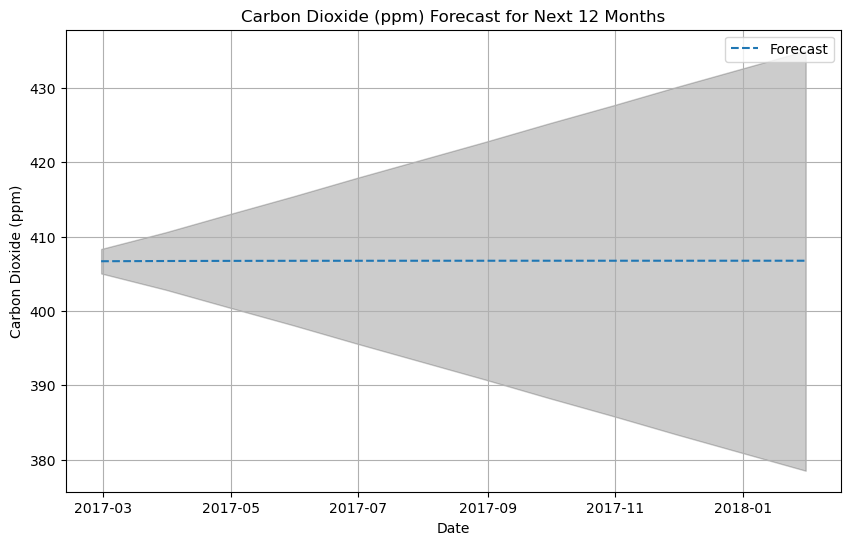

In [156]:
# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(forecast_dates, absolute_forecast, label='Forecast', linestyle='--')
if 'Carbon Dioxide Diff' in df.columns:
    plt.fill_between(forecast_dates, last_observed_value + forecast_ci.iloc[:, 0].cumsum(), last_observed_value + forecast_ci.iloc[:, 1].cumsum(), color='k', alpha=0.2)
else:
    plt.fill_between(forecast_dates, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=0.2)
plt.title('Carbon Dioxide (ppm) Forecast for Next 12 Months')
plt.xlabel('Date')
plt.ylabel('Carbon Dioxide (ppm)')
plt.legend()
plt.grid(True)
plt.show()